Collect stock and option data, price with BSM, compare accuracy

In [1]:
# !pip install yfinance
# !pip install seaborn

import pandas as pd

from math import sqrt
import numpy as np
from scipy.stats import norm

import seaborn as sns

In [2]:
from datetime import datetime, timezone, timedelta

# exp of Nov 16 2020

timestamp = 1605484800 # exp of Nov 16 2020
# timestamp = 1605657600 # exp of Nov 18 2020

datetime.fromtimestamp(timestamp) # need to add 5 hours (same as UTC)

# create a timestamp for scraping from a given date and time (UTC)
# expiration_datetime = datetime(2020, 11, 16, 0, 0, tzinfo=timezone.utc)\
expiration_datetime = datetime(2020, 12, 4, 0, 0, tzinfo=timezone.utc)
# expiration_datetime = datetime(2020, 12, 31, 0, 0, tzinfo=timezone.utc)

expiration_timestamp = int(expiration_datetime.timestamp())
print(expiration_timestamp)

1607040000


In [3]:
print(expiration_datetime.date())

2020-12-04


Download historical stock price data for SPY. I get a past year's worth from (https://finance.yahoo.com/quote/SPY/history?p=SPY)

In [4]:
# download annual historical data for the stock

ticker = 'TSLA'
stock_price_path = "~/documents/quant_finance/price_data/{}.csv".format(ticker)
df = pd.read_csv(stock_price_path)
df = df.sort_values(by="Date")
df = df.dropna()

# calculate returns
df = df.assign(close_day_before=df['Adj Close'].shift(1))
df['returns'] = ((df['Adj Close'] - df.close_day_before)/df.close_day_before)

# get options data
options_data_path = 'https://finance.yahoo.com/quote/{}/options?date={}&p={}'.format(ticker, expiration_timestamp, ticker)
options_data = pd.read_html(options_data_path) # returns two dataframes, for calls and puts
r = options_data[0]
calls_df = options_data[1]

print(df)
print(r)

           Date        Open        High         Low       Close   Adj Close  \
0    2019-11-14   69.222000   70.767998   68.582001   69.870003   69.870003   
1    2019-11-15   70.127998   70.559998   69.671997   70.433998   70.433998   
2    2019-11-18   70.584000   70.629997   69.220001   69.998001   69.998001   
3    2019-11-19   70.349998   71.998001   69.559998   71.903999   71.903999   
4    2019-11-20   72.000000   72.239998   69.914001   70.444000   70.444000   
..          ...         ...         ...         ...         ...         ...   
248  2020-11-09  439.500000  452.500000  421.000000  421.260010  421.260010   
249  2020-11-10  420.089996  420.089996  396.029999  410.359985  410.359985   
250  2020-11-11  416.450012  418.700012  410.579987  417.130005  417.130005   
251  2020-11-12  415.049988  423.000000  409.519989  411.760010  411.760010   
252  2020-11-13  410.850006  412.529999  401.660004  408.500000  408.500000   

       Volume  close_day_before   returns  
0    32

In [5]:
# S is the spot price 
# K is the strike price 
# T is the fraction of days to strike date divided by 252 (stock market days)
# r is the risk free rate
# sigma is the annual volatility of the returns of the stock 

def black_scholes(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma * sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K*np.exp(-r*T) * norm.cdf(d2)

# get the (num days to expiration) / (trading days in a year)
def get_time_to_expiration(expiration_datetime_utc):
    return (expiration_datetime_utc - datetime.now(timezone.utc)).days / 252


In [7]:
# the rfr should vary with time, not be constant.

cur_stock_price = df.iloc[-1]['Adj Close']
time_to_expiration = get_time_to_expiration(expiration_datetime)
risk_free_rate = 0.0069
# Calculate the volatility as the annualized standard deviation of the stock returns
sigma = np.sqrt(252) * df['returns'].std()

print('cur_stock_price: {}, time to expiration: {}, rfr: {}, vol: {}'.format(cur_stock_price, time_to_expiration, risk_free_rate, sigma))
list_estimates = []

strike_start_idx, strike_end_idx = 0, r.shape[0]
# strike_start_idx, strike_end_idx = 0, 21

# run BSM for different strikes
for x in range(strike_start_idx,strike_end_idx):
    value_s = black_scholes(S = cur_stock_price, 
                            K = r['Strike'][x], 
                            T = time_to_expiration, 
                            r = risk_free_rate, 
                            sigma = sigma)
    list_estimates.append(value_s)
    
# merge the real and computed dataframes to compare results
df_list = pd.DataFrame(data=list_estimates, index=r.index[strike_start_idx:strike_end_idx])
df_list['estimate'] = df_list[0]
del df_list[0]
df_estimate = r.merge(df_list, right_index = True, left_index = True)

cur_stock_price: 408.5, time to expiration: 0.06349206349206349, rfr: 0.0069, vol: 0.8736802392964274


In [8]:
df_estimate

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,estimate
0,TSLA201204C00020000,2020-11-16 12:10AM EST,20.0,411.95,427.00,431.75,0.00,-,-,-,858.79%,388.508760
1,TSLA201204C00250000,2020-11-06 3:10PM EST,250.0,160.40,198.85,204.15,0.00,-,1,4,185.94%,158.921244
2,TSLA201204C00260000,2020-11-16 2:07PM EST,260.0,149.06,187.35,192.10,0.00,-,1,1,158.06%,149.137290
3,TSLA201204C00270000,2020-11-17 9:36AM EST,270.0,183.35,177.00,182.15,44.30,+31.86%,3,11,147.12%,139.459009
4,TSLA201204C00280000,2020-11-16 3:25PM EST,280.0,175.65,169.20,173.85,46.55,+36.06%,1,17,155.75%,129.920454
...,...,...,...,...,...,...,...,...,...,...,...,...
73,TSLA201204C00720000,2020-11-17 10:17AM EST,720.0,1.04,0.97,1.08,0.94,+940.00%,48,16,105.74%,0.189718
74,TSLA201204C00740000,2020-11-17 10:27AM EST,740.0,0.90,0.81,0.94,0.57,+172.73%,52,8,108.06%,0.128917
75,TSLA201204C00760000,2020-11-17 10:24AM EST,760.0,0.80,0.71,0.80,0.74,"+1,233.33%",99,15,110.35%,0.087378
76,TSLA201204C00780000,2020-11-17 10:16AM EST,780.0,0.70,0.62,0.77,0.66,"+1,650.00%",13,37,113.48%,0.059094


<AxesSubplot:title={'center':'Computed v Market prices for TSLA, Expiry 2020-12-04'}, xlabel='Strike'>

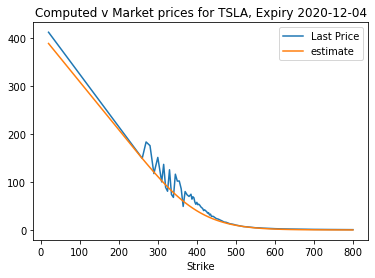

In [9]:
# plot option prices across strikes

df_estimate.plot(x='Strike',y=['Last Price','estimate'], title='Computed v Market prices for {}, Expiry {}'.format(ticker, expiration_datetime.date()))

count      78.000000
mean       88.298194
std       228.984568
min       -18.477548
25%         9.061692
50%        33.057897
75%        43.299833
max      1404.091158
Name: estimate_error, dtype: float64


/home/amao/miniconda3/envs/datasci/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


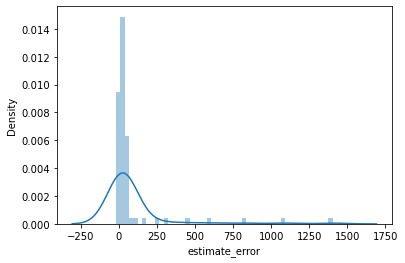

In [10]:
df_estimate['estimate_error'] = ((df_estimate['Last Price'] - df_estimate['estimate'])/df_estimate['estimate'])*100
ax = sns.distplot(df_estimate['estimate_error'])
print(df_estimate['estimate_error'].describe())

# across strikes, the median error is 34%, but there is a huge spread and outliers, 
# which mainly seem to be due to the higher strikes being very close to 0.

In [11]:
# examine outliers

df_estimate[df_estimate['estimate_error'].abs() > 1]

# the model tends to undervalue puts especially at high strikes (deep out of the money).

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,estimate,estimate_error
0,TSLA201204C00020000,2020-11-16 12:10AM EST,20.0,411.95,427.00,431.75,0.00,-,-,-,858.79%,388.508760,6.033645
3,TSLA201204C00270000,2020-11-17 9:36AM EST,270.0,183.35,177.00,182.15,44.30,+31.86%,3,11,147.12%,139.459009,31.472324
4,TSLA201204C00280000,2020-11-16 3:25PM EST,280.0,175.65,169.20,173.85,46.55,+36.06%,1,17,155.75%,129.920454,35.198111
5,TSLA201204C00290000,2020-11-13 3:21PM EST,290.0,117.45,158.75,163.35,0.00,-,1,5,142.52%,120.559828,-2.579490
6,TSLA201204C00300000,2020-11-17 10:23AM EST,300.0,151.12,148.05,152.45,42.75,+39.45%,4,31,127.05%,111.418180,35.633161
...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,TSLA201204C00720000,2020-11-17 10:17AM EST,720.0,1.04,0.97,1.08,0.94,+940.00%,48,16,105.74%,0.189718,448.182990
74,TSLA201204C00740000,2020-11-17 10:27AM EST,740.0,0.90,0.81,0.94,0.57,+172.73%,52,8,108.06%,0.128917,598.122916
75,TSLA201204C00760000,2020-11-17 10:24AM EST,760.0,0.80,0.71,0.80,0.74,"+1,233.33%",99,15,110.35%,0.087378,815.565192
76,TSLA201204C00780000,2020-11-17 10:16AM EST,780.0,0.70,0.62,0.77,0.66,"+1,650.00%",13,37,113.48%,0.059094,1084.561852


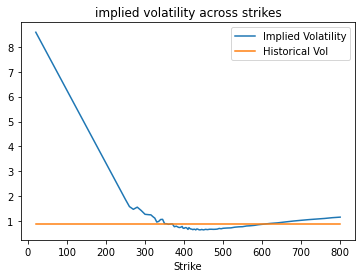

In [26]:
# df_estimate['Implied Volatility'] = df_estimate['Implied Volatility'].str.slice(stop=-1).astype('float') / 100

df_estimate['Historical Vol'] = sigma
ax = df_estimate.plot(x='Strike',y=['Implied Volatility','Historical Vol'],title='volatility across strikes')


<AxesSubplot:title={'center':'volume'}, xlabel='Strike'>

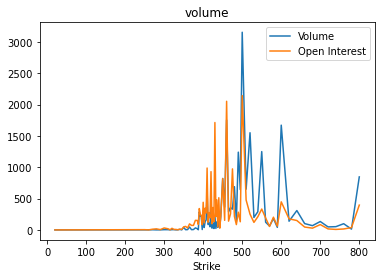

In [23]:
df_estimate['Volume'] = df_estimate['Volume'].replace(to_replace='-',value=0)
df_estimate['Volume'] = df_estimate['Volume'].astype('int')

df_estimate['Open Interest'] = df_estimate['Open Interest'].replace(to_replace='-',value=0)
df_estimate['Open Interest'] = df_estimate['Open Interest'].astype('int')

df_estimate.plot(x='Strike',y=['Volume','Open Interest'],title='volume and open interest')

<AxesSubplot:title={'center':'estimate error across strikes'}, xlabel='Strike'>

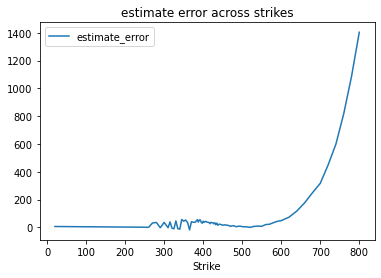

In [24]:
# plot the error across strikes

df_estimate.plot(x='Strike',y='estimate_error',title='estimate error across strikes')


count    67.000000
mean     23.845204
std      18.777165
min     -18.477548
25%       8.201206
50%      26.096129
75%      36.938044
max      56.762143
Name: estimate_error, dtype: float64


/home/amao/miniconda3/envs/datasci/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Computed v Market prices for TSLA, Expiry 2020-12-04'}, xlabel='Strike'>

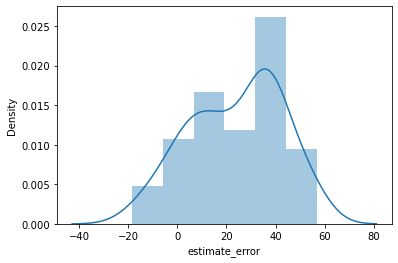

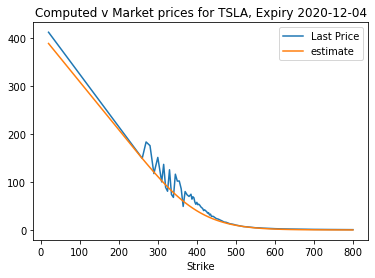

In [29]:
# filter deep ITM and OTM options

lower_bound, upper_bound = cur_stock_price * .5, cur_stock_price * 1.5
put_estimate_filtered = df_estimate[(df_estimate['Strike'] > lower_bound) & (df_estimate['Strike'] < upper_bound)]
ax = sns.distplot(put_estimate_filtered['estimate_error'])
print(put_estimate_filtered['estimate_error'].describe())

df_estimate.plot(x='Strike',y=['Last Price','estimate'], title='Computed v Market prices for {}, Expiry {}'.format(ticker, expiration_datetime.date()))